In [1]:
import pandas as pd
import numpy as np

In [2]:
test_features = pd.read_csv("test_features.csv", index_col = 0)
training_features = pd.read_csv("training_features.csv", index_col = 0)

In [3]:
test_feat_fill = test_features.copy()
test_feat_fill = test_feat_fill.replace([np.inf, -np.inf], np.nan)
test_feat_fill =test_feat_fill.fillna(test_feat_fill.mean())

In [4]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [5]:
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers

Using TensorFlow backend.


In [6]:
class Model:
    def __init__(self, train_set, test_set):
        self.train_set = train_set
        self.test_set = test_set
        
        X = train_set.iloc[:,1:]
        y = train_set.iloc[:,0].map(lambda x: 1 if x == True else 0 )
        
        self.X = X
        self.y = y
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=33)
        
        
    def Random_Forest(self):
        rf_model = RandomForestClassifier(n_estimators=300, 
                                  max_depth=10,
                                  random_state=100,
                                    max_features=0.5,
                                    min_samples_leaf=5)
        
        cv_results = cross_validate(rf_model, self.X_train, self.y_train, cv=3,
                            scoring= 'roc_auc',
                            return_train_score=True,
                            return_estimator =True)
        
        rf_model.fit(self.X_train, self.y_train)
        
        importance = pd.Series(rf_model.feature_importances_, index=self.X_train.columns)
        self.rf_importance = importance.sort_values()[-15:] # show top 15
        
        return rf_model.predict_proba(self.test_set)[:,1]
    
    def LGB(self):
        bst = lgb.LGBMClassifier(boosting_type= 'gbdt',
                        objective = 'binary',
                        max_depth = 3,
                        n_estimators = 1000)

        bst.fit(self.X_train.values, self.y_train.values)
        
        importance = pd.Series(bst.feature_importances_, index=self.X_train.columns)
        self.GBM_importance = importance.sort_values()[-15:] # show top 15
        
        return bst.predict_proba(self.test_set)[:,1]
    
    def Neural_Net(self):
        scaler = StandardScaler()
        scaler.fit(self.X)
        
        X_scale = scaler.transform(self.X)
        y_array = self.y.values
        
        X_train, X_test_s, y_train, y_test = train_test_split(X_scale, y_array, test_size=0.33, random_state=33)
        X_train_mlp, X_validation, y_train_mlp, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=33)
        
        model = Sequential()

        #First Hidden Layer
        model.add(Dense(128, activation='relu', kernel_initializer='random_normal', input_dim=X_train.shape[1]))

        #Second  Hidden Layer
        model.add(Dense(64, activation='relu', kernel_initializer='random_normal'))    
        
        #Output Layer
        model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        # add early stop to prevent overfitting
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
        mc = ModelCheckpoint('best_model2.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

        history = model.fit(X_train, y_train,
                            validation_split = 0.15,
                            epochs=4000, verbose=0, callbacks=[es, mc])

        saved_model = load_model('best_model2.h5')
        
        #scale test data
        scaler.fit(self.test_set)
        X_test_scale = scaler.transform(self.test_set)
        
        NN_predict = saved_model.predict_proba(X_test_scale)
        nn_prob = np.array([ x[0] for x in NN_predict])
        
        self.weights, self.biases = saved_model.layers[0].get_weights()
        
        return nn_prob
    
    def predict(self):
        rf_predictions = self.Random_Forest()
        lgb_predictions = self.LGB()
        #nn_predictions = self.Neural_Net()
        
        self.predictions = pd.DataFrame({'LGB':lgb_predictions,
                                         'Random Forest':rf_predictions,
                                         #'Neural Net':nn_predictions
                                          }, 
                                          index = self.test_set.index)

        #self.predictions['Model Average'] = self.predictions.mean(axis = 1)
        self.predictions['RF+LGB'] = (self.predictions['LGB']+self.predictions['Random Forest'])/2
        
        return self.predictions

In [7]:
%%time
validationModel = Model(train_set=training_features, test_set=test_feat_fill)
validation_predictions = validationModel.predict()

Wall time: 1min 22s


In [8]:
patient1 = test_feat_fill[test_feat_fill.index == 'ID38179240346']
patient2 = test_feat_fill[test_feat_fill.index == 'ID14418595663']
patient3 = test_feat_fill[test_feat_fill.index == 'ID4467853207']

In [9]:
def change_inital(patient_features, new_SC_0):
    old_SC_0 = patient_features['SUPPLY_CNT_on_day0'].values[0]
    
    mult_factor = new_SC_0/old_SC_0
    divide_factor = old_SC_0/new_SC_0
    
    mme = patient_features[['MME_on_day0']]
    
    sc = patient_features[['SUPPLY_CNT_on_day0']]*(mult_factor)
    
    initials = patient_features[['PAYABLE_QTY_on_day0',
       'max_MME_prior', 'avg_MME_prior', 'total_SUPPLY_CNT_prior',
       'total_PAYABLE_QTY_prior', 'opioid_cost_on_day_0',
       'opioid_net_payment_on_day_0', 'supply_times', 'total_costs_on_day_0',
       'total_net_payment_on_day_0', 'net_payment_portion_on_day_0',
       'opioid_cost_portion_on_day_0']]
    
    mme_sc = patient_features[['MME_times_SUPPLY_day_0']]*(mult_factor)
    
    divide = patient_features[['total_cost_divide_SUPPLY_day_0', 'total_net_payment_divide_on_day_0',
       'np_portion_divide_SUPPLY_day_0', 'oc_portion_divide_SUPPLY_day_0',
       'max_MME_prior_divide_SUPPLY_day_0',
       'avg_MME_prior_divide_SUPPLY_day_0', 'tsc_prior_divide_SUPPLY_day_0',
       'tpa_prior_divide_SUPPLY_day_0', 'oc_day_0_divide_SUPPLY_day_0',
       'np_day_0_divide_SUPPLY_day_0']]*(divide_factor)
    
    pcs = patient_features[['generic_pc0', 'generic_pc1',
       'generic_pc2', 'generic_pc3', 'generic_pc4', 'generic_pc5',
       'generic_pc6', 'generic_pc7', 'generic_pc8', 'generic_pc9']]
    
    concat = pd.concat([mme, sc, initials, mme_sc, divide, pcs], axis = 1)
    
    return concat

## Make a range for each patient

## Function to do this

In [10]:
def get_prediction_range(patient_features, sc_low, sc_high, step):
    
    patient_options = []
    
    for sc in range(sc_low, sc_high, step):
        df = change_inital(patient_features, sc)
        patient_options.append(df)
        
    patient_options = pd.concat(patient_options)
    
    new_model = Model(train_set=training_features, test_set=pd.concat([test_feat_fill, patient_options]))
    new_predictions = new_model.predict()
    
    return new_predictions.iloc[-len(patient_options):]

In [11]:
min_sc = 1
max_sc = 50

In [12]:
%%time
patient1_range = get_prediction_range(patient1, min_sc, max_sc, 1)
patient2_range = get_prediction_range(patient2, min_sc, max_sc, 1)
patient3_range = get_prediction_range(patient3, min_sc, max_sc, 1)

Wall time: 4min 14s


In [13]:
ranges = [patient1_range, patient2_range, patient3_range]
patients = [patient1, patient2, patient3]

In [14]:
patient_inital_sc = []

for patient in patients:
    sc = test_features[test_features.index == patient.index[0]]['SUPPLY_CNT_on_day0'][0]
    pred = validation_predictions[validation_predictions.index == patient.index[0]]['RF+LGB'].values[0]
    
    patient_inital_sc.append((sc, pred))

In [15]:
patient_inital_sc

[(30.0, 0.9955992543841881),
 (4.0, 0.0794937870283533),
 (30.0, 0.586192929187944)]

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

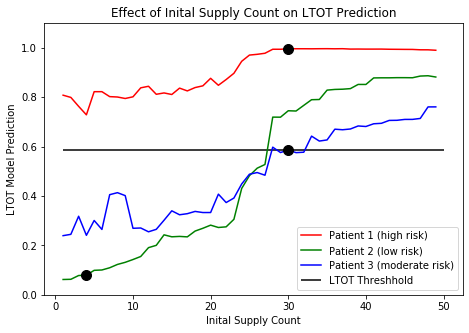

In [47]:
labels = ['Patient 1 (high risk)', 'Patient 2 (low risk)', 'Patient 3 (moderate risk)']
colors = ['red', 'green', 'blue']

plt.figure(figsize=(7.5,5))
plt.ylim((0, 1.1))

for count, patient in enumerate(ranges):
    plt.plot(range(min_sc, max_sc), 
             patient['RF+LGB'].values, 
             label = labels[count],
             color = colors[count])

for inital in patient_inital_sc:
    plt.scatter(*inital, color = 'black', s=100, zorder = 3)

plt.hlines(y=.586, xmin=min_sc, xmax=max_sc, label = "LTOT Threshhold")
plt.xlabel('Inital Supply Count')
plt.ylabel('LTOT Model Prediction')
plt.legend()
plt.title("Effect of Inital Supply Count on LTOT Prediction") 
plt.savefig('full.png',dpi=750)
plt.show()

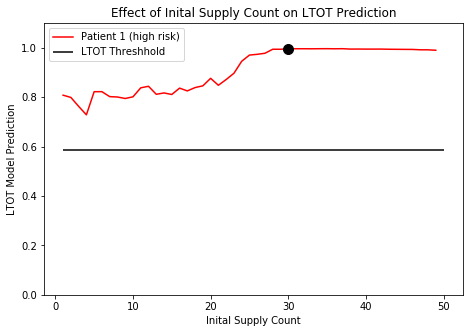

In [44]:
plt.figure(figsize=(7.5,5))
plt.ylim((0, 1.1))

plt.plot(range(min_sc, max_sc), 
     ranges[0]['RF+LGB'].values, 
     label = labels[0],
     color = colors[0])

plt.scatter(*patient_inital_sc[0], color = 'black', s=100, zorder = 3)

plt.hlines(y=.586, xmin=min_sc, xmax=max_sc, label = "LTOT Threshhold")
plt.xlabel('Inital Supply Count')
plt.ylabel('LTOT Model Prediction')
plt.legend()
plt.title("Effect of Inital Supply Count on LTOT Prediction") 
plt.savefig('p1.png',dpi=750)
plt.show()

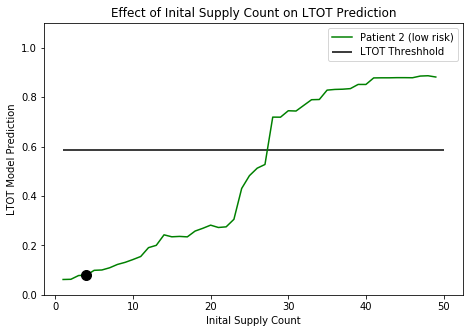

In [45]:
plt.figure(figsize=(7.5,5))
plt.ylim((0, 1.1))

plt.plot(range(min_sc, max_sc), 
     ranges[1]['RF+LGB'].values, 
     label = labels[1],
     color = colors[1])

plt.scatter(*patient_inital_sc[1], color = 'black', s=100, zorder = 3)

plt.hlines(y=.586, xmin=min_sc, xmax=max_sc, label = "LTOT Threshhold")
plt.xlabel('Inital Supply Count')
plt.ylabel('LTOT Model Prediction')
plt.legend()
plt.title("Effect of Inital Supply Count on LTOT Prediction") 
plt.savefig('p2.png',dpi=750)
plt.show()

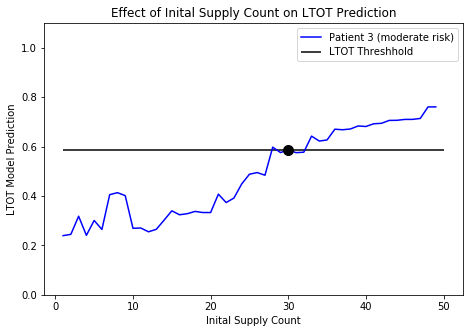

In [46]:
plt.figure(figsize=(7.5,5))
plt.ylim((0, 1.1))

plt.plot(range(min_sc, max_sc), 
     ranges[2]['RF+LGB'].values, 
     label = labels[2],
     color = colors[2])

plt.scatter(*patient_inital_sc[2], color = 'black', s=100, zorder = 3)

plt.hlines(y=.586, xmin=min_sc, xmax=max_sc, label = "LTOT Threshhold")
plt.xlabel('Inital Supply Count')
plt.ylabel('LTOT Model Prediction')
plt.legend()
plt.title("Effect of Inital Supply Count on LTOT Prediction") 
plt.savefig('p3.png',dpi=750)
plt.show()

## MME Range

In [21]:
# test_feat_fill.MME_on_day0.min()

In [22]:
# test_feat_fill.MME_on_day0.median()

In [23]:
# def change_inital_mme(patient_features, new_MME_0):
#     old_MME_0 = patient_features['MME_on_day0'].values[0]
    
#     MME_factor = new_MME_0/old_MME_0
    
#     mme = patient_features[['MME_on_day0']]*MME_factor
    
#     sc = patient_features[['SUPPLY_CNT_on_day0']]
    
#     initials = patient_features[['PAYABLE_QTY_on_day0',
#        'max_MME_prior', 'avg_MME_prior', 'total_SUPPLY_CNT_prior',
#        'total_PAYABLE_QTY_prior', 'opioid_cost_on_day_0',
#        'opioid_net_payment_on_day_0', 'supply_times', 'total_costs_on_day_0',
#        'total_net_payment_on_day_0', 'net_payment_portion_on_day_0',
#        'opioid_cost_portion_on_day_0']]
    
#     mme_sc = patient_features[['MME_times_SUPPLY_day_0']]*(MME_factor)
    
#     divide = patient_features[['total_cost_divide_SUPPLY_day_0', 'total_net_payment_divide_on_day_0',
#        'np_portion_divide_SUPPLY_day_0', 'oc_portion_divide_SUPPLY_day_0',
#        'max_MME_prior_divide_SUPPLY_day_0',
#        'avg_MME_prior_divide_SUPPLY_day_0', 'tsc_prior_divide_SUPPLY_day_0',
#        'tpa_prior_divide_SUPPLY_day_0', 'oc_day_0_divide_SUPPLY_day_0',
#        'np_day_0_divide_SUPPLY_day_0']]
    
#     pcs = patient_features[['generic_pc0', 'generic_pc1',
#        'generic_pc2', 'generic_pc3', 'generic_pc4', 'generic_pc5',
#        'generic_pc6', 'generic_pc7', 'generic_pc8', 'generic_pc9']]
    
#     concat = pd.concat([mme, sc, initials, mme_sc, divide, pcs], axis = 1)
    
#     return concat

In [24]:
# def get_prediction_range_mme(patient_features, mme_low, mme_high, step):
    
#     patient_options = []
    
#     for sc in range(mme_low, mme_high, step):
#         df = change_inital_mme(patient_features, sc)
#         patient_options.append(df)
        
#     patient_options = pd.concat(patient_options)
    
#     new_model = Model(train_set=training_features, test_set=pd.concat([test_feat_fill, patient_options]))
#     new_predictions = new_model.predict()
    
#     return new_predictions.iloc[-len(patient_options):]

In [25]:
# min_mme = 1
# max_mme = 50
# mme_step = 1

In [26]:
# %%time
# patient1_range_mme = get_prediction_range_mme(patient1, min_mme, max_mme, mme_step)
# patient2_range_mme = get_prediction_range_mme(patient2, min_mme, max_mme, mme_step)
# patient3_range_mme = get_prediction_range_mme(patient3, min_mme, max_mme, mme_step)

In [27]:
# mme_ranges = [patient1_range_mme, patient2_range_mme, patient3_range_mme]

In [28]:
# patient_inital_mme = []

# for patient in patients:
#     mme = test_features[test_features.index == patient.index[0]]['MME_on_day0'][0]
#     pred = validation_predictions[validation_predictions.index == patient.index[0]]['RF+LGB'].values[0]
    
#     patient_inital_mme.append((mme, pred))

In [29]:
# patient_inital_mme

In [30]:
# labels = ['Patient 1 (high risk)', 'Patient 2 (low risk)', 'Patient 3 (moderate risk)']
# colors = ['red', 'green', 'blue']

# plt.figure(figsize=(7.5,5))
# plt.ylim((0, 1.1))

# for count, patient in enumerate(mme_ranges):
#     plt.plot(range(min_mme, max_mme, mme_step), 
#              patient['RF+LGB'].values, 
#              label = labels[count],
#              color = colors[count])

# for inital in patient_inital_mme:
#     plt.scatter(*inital, color = 'black', s=100, zorder = 3)

# plt.hlines(y=.586, xmin=min_mme, xmax=max_mme, label = "LTOT Threshhold")
# plt.xlabel('Inital MME')
# plt.ylabel('LTOT Model Prediction')
# plt.legend(loc='center left', bbox_to_anchor=(.57, .1225))
# plt.savefig('full_mme.png')
# plt.show()

In [31]:
# plt.figure(figsize=(7.5,5))
# plt.ylim((0, 1.1))

# plt.plot(range(min_mme, max_mme, mme_step), 
#      mme_ranges[0]['RF+LGB'].values, 
#      label = labels[0],
#      color = colors[0])

# plt.scatter(*patient_inital_mme[0], color = 'black', s=100, zorder = 3)

# plt.hlines(y=.586, xmin=min_mme, xmax=max_mme, label = "LTOT Threshhold")
# plt.xlabel('Inital MME')
# plt.ylabel('LTOT Model Prediction')
# plt.legend()
# plt.savefig('p1_mme.png')
# plt.show()

In [32]:
# plt.figure(figsize=(7.5,5))
# plt.ylim((0, 1.1))

# plt.plot(range(min_mme, max_mme, mme_step), 
#      mme_ranges[1]['RF+LGB'].values, 
#      label = labels[1],
#      color = colors[1])

# plt.scatter(*patient_inital_mme[1], color = 'black', s=100, zorder = 3)

# plt.hlines(y=.586, xmin=min_mme, xmax=max_mme, label = "LTOT Threshhold")
# plt.xlabel('Inital MME')
# plt.ylabel('LTOT Model Prediction')
# plt.legend()
# plt.savefig('p2_mme.png')
# plt.show()

In [33]:
# plt.figure(figsize=(7.5,5))
# plt.ylim((0, 1.1))

# plt.plot(range(min_mme, max_mme, mme_step), 
#      mme_ranges[2]['RF+LGB'].values, 
#      label = labels[2],
#      color = colors[2])

# plt.scatter(*patient_inital_mme[2], color = 'black', s=100, zorder = 3)

# plt.hlines(y=.586, xmin=min_mme, xmax=max_mme, label = "LTOT Threshhold")
# plt.xlabel('Inital MME')
# plt.ylabel('LTOT Model Prediction')
# plt.legend()
# plt.savefig('p3_mme.png')
# plt.show()

## Changing Total Prior Supply Count

In [34]:
def change_prior_sc(patient_features, new_prior_sc):
    old_sc_prior = patient_features['total_SUPPLY_CNT_prior'].values[0]
    
    const1 = patient_features[['MME_on_day0', 'SUPPLY_CNT_on_day0', 'PAYABLE_QTY_on_day0',
       'max_MME_prior', 'avg_MME_prior']]
    
    prior = patient_features[['total_SUPPLY_CNT_prior']].copy()
    prior.iloc[0] = new_prior_sc
    
    
    const2 = patient_features[['total_PAYABLE_QTY_prior', 'opioid_cost_on_day_0',
       'opioid_net_payment_on_day_0', 'supply_times', 'total_costs_on_day_0',
       'total_net_payment_on_day_0', 'net_payment_portion_on_day_0',
       'opioid_cost_portion_on_day_0', 'MME_times_SUPPLY_day_0',
       'total_cost_divide_SUPPLY_day_0', 'total_net_payment_divide_on_day_0',
       'np_portion_divide_SUPPLY_day_0', 'oc_portion_divide_SUPPLY_day_0',
       'max_MME_prior_divide_SUPPLY_day_0',
       'avg_MME_prior_divide_SUPPLY_day_0']]
    
    prior2 = patient_features[['tsc_prior_divide_SUPPLY_day_0']].copy()
    prior2.iloc[0] = new_prior_sc/patient_features.SUPPLY_CNT_on_day0[0]
    
    const3 = patient_features[['tpa_prior_divide_SUPPLY_day_0', 'oc_day_0_divide_SUPPLY_day_0',
       'np_day_0_divide_SUPPLY_day_0', 'generic_pc0', 'generic_pc1',
       'generic_pc2', 'generic_pc3', 'generic_pc4', 'generic_pc5',
       'generic_pc6', 'generic_pc7', 'generic_pc8', 'generic_pc9']]
    
    concat = pd.concat([const1, prior, const2, prior2, const3], axis = 1)
    
    return concat

In [35]:
test_features.total_SUPPLY_CNT_prior.describe()

count    5997.000000
mean      174.296315
std       290.068399
min         0.000000
25%         0.000000
50%        30.000000
75%       240.000000
max      2644.000000
Name: total_SUPPLY_CNT_prior, dtype: float64

In [36]:
def get_prediction_range_prior_sc(patient_features, prior_low, prior_high, step):
    
    patient_options = []
    
    for sc in range(prior_low, prior_high, step):
        df = change_prior_sc(patient_features, sc)
        patient_options.append(df)
        
    patient_options = pd.concat(patient_options)
    
    new_model = Model(train_set=training_features, test_set=pd.concat([test_feat_fill, patient_options]))
    new_predictions = new_model.predict()
    
    return new_predictions.iloc[-len(patient_options):]

In [37]:
prior_min = 1
prior_max = 1001
prior_step = 50

In [38]:
%%time
patient1_range_prior = get_prediction_range_prior_sc(patient1, prior_min, prior_max, prior_step)
patient2_range_prior = get_prediction_range_prior_sc(patient2, prior_min, prior_max, prior_step)
patient3_range_prior = get_prediction_range_prior_sc(patient3, prior_min, prior_max, prior_step)

Wall time: 3min 52s


In [39]:
prior_ranges = [patient1_range_prior,
                patient2_range_prior,
                patient3_range_prior]

In [40]:
patient_inital_prior = []

for patient in patients:
    prior = patient.total_SUPPLY_CNT_prior[0]
    pred = validation_predictions[validation_predictions.index == patient.index[0]]['RF+LGB'].values[0]
    
    patient_inital_prior.append((prior, pred))

In [41]:
patient_inital_prior

[(960.0, 0.9955992543841881),
 (0.0, 0.0794937870283533),
 (34.0, 0.586192929187944)]

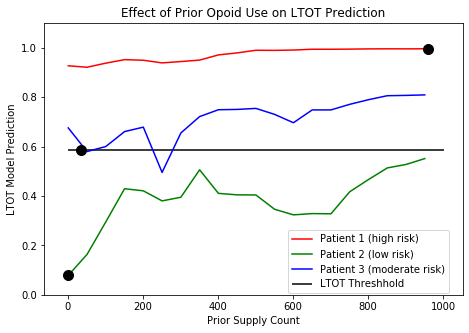

In [48]:
labels = ['Patient 1 (high risk)', 'Patient 2 (low risk)', 'Patient 3 (moderate risk)']
colors = ['red', 'green', 'blue']

plt.figure(figsize=(7.5,5))
plt.ylim((0, 1.1))

for count, patient in enumerate(prior_ranges):
    plt.plot(range(prior_min, prior_max, prior_step), 
             patient['RF+LGB'].values, 
             label = labels[count],
             color = colors[count])

for inital in patient_inital_prior:
    plt.scatter(*inital, color = 'black', s=100, zorder = 3)

plt.hlines(y=.586, xmin=prior_min, xmax=prior_max, label = "LTOT Threshhold")
plt.xlabel('Prior Supply Count')
plt.ylabel('LTOT Model Prediction')
plt.legend(loc='center left', bbox_to_anchor=(.57, .1225))
plt.title("Effect of Prior Opoid Use on LTOT Prediction") 
plt.savefig('full_prior.png',dpi=750)
plt.show()

## Graph High DPI

In [52]:
predictions = pd.read_csv("validation_predictions.csv", index_col = 0)

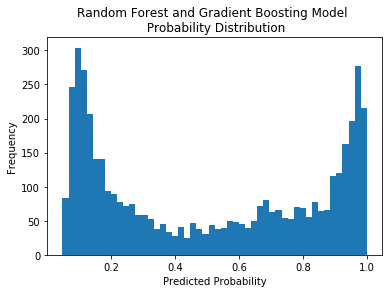

In [54]:
predictions['RF+LGB'].plot(kind = 'hist', bins = 50)
plt.title('Random Forest and Gradient Boosting Model \n Probability Distribution')
plt.xlabel('Predicted Probability')
plt.savefig("rf_gb.png", dpi=750)

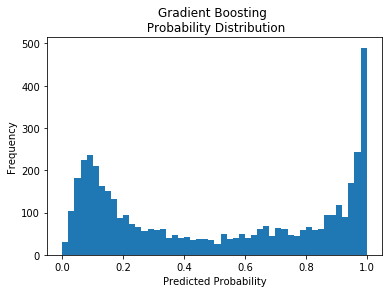

In [57]:
predictions['LGB'].plot(kind = 'hist', bins = 50)
plt.title('Gradient Boosting \n Probability Distribution')
plt.xlabel('Predicted Probability')
plt.savefig("gb.png", dpi=750)

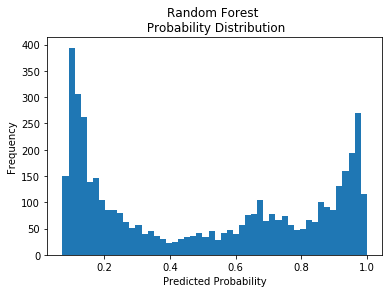

In [58]:
predictions['Random Forest'].plot(kind = 'hist', bins = 50)
plt.title('Random Forest \n Probability Distribution')
plt.xlabel('Predicted Probability')
plt.savefig("rf.png", dpi=750)

In [59]:
model = Model(train_set=training_features, test_set=test_feat_fill)
predictions = model.predict()

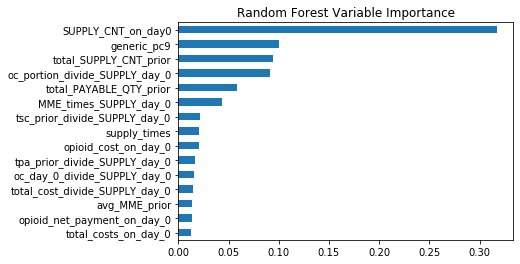

In [62]:
model.rf_importance.plot.barh()
plt.title('Random Forest Variable Importance')
plt.savefig("rf_imp.png", dpi=750, bbox_inches="tight")

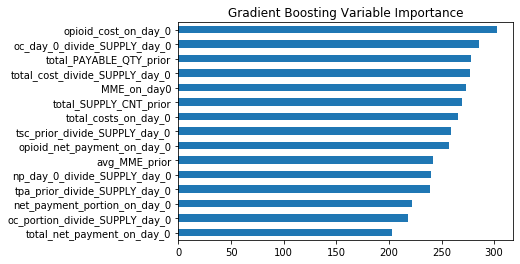

In [63]:
model.GBM_importance.plot.barh()
plt.title('Gradient Boosting Variable Importance')
plt.savefig("gb_imp.png", dpi=750, bbox_inches="tight")